## Potential Talents - Part 5

----

## Instruction FT for Job-Title Similarity

**Objective.** Train a small instruction-tuned LLM to score **0–100** similarity between a **query** job title and **candidates**, then rank them. The LLM refines a fast SBERT first pass into higher-quality ordering.

**Constraints.** 
- single GPU **GTX 1080 Ti (11GB)**
- rely on **NVMe** disk for offload/swap
- short sequences
- **LoRA** only

**Model.** 
- `meta-llama/Llama-3.2-3B-Instruct`, compact, instruction-following, stable tokenizer/chat template, good at short-text matching. 
- Runs comfortably with LoRA on 1080 Ti.
  

**Method (steps):**

1) Imports, config, folders  
2) Preprocessing & EDA (normalize titles, drop noise/dupes)  
3) **Gross retrieval**: SBERT + cosine → top-N, score in 0–100  
4) **Fine retrieval**: LLM ranker
   
   -3.1 Build bin-balanced pairs per query. Collect SBERT + LLM (v1/v2) scores  
   -3.2 Blend scores, flag disagreements, export train/val/test JSONL (target = final weighted)

**[Part 5t]**

4) **Instruction FT**: causal LM with prompt-masking, LoRA on Llama-3.2-3B  
5) **Eval & logs**: train/eval loss, LR curve, CSV log, compact `summary.json`. Save adapter + tokenizer



----


### 0. Imports, configuration and folders

In [1]:
# core
import os, json, gc
import numpy as np
import pandas as pd
import re, unicodedata
import torch
import random
import tools_llm_ift
import torch

# display config
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

In [2]:
tools_llm_ift.free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 0.0 MiB | reserved: 0.0 MiB | total: 11,264 MiB

After:
allocated: 0.0 MiB | reserved: 0.0 MiB | total: 11,264 MiB


In [3]:
# GPU configuration details
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [4]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# paths
DATA_DIR = "data"
OUT_DIR  = "outputs"

# datasets
base_ds_file = os.path.join(DATA_DIR, "extended_clean.csv")
extended_df_file = "Extended Dataset for Potential Talents.xlsx" 


----

### 1. Preprocessing and EAD


We load the extended dataset, **normalize titles** (Unicode NFKC, remove zero-width chars, collapse whitespace), and compute quick features (`title_len`, `alpha_ratio`). 

Using simple quality rules (empty/bad tokens, punctuation-only, too short, low alpha ratio), we **filter noisy entries** and then **deduplicate** by a case-folded key to keep one representative per title. 

We report counts/memory, preview examples of what gets dropped, and persist the cleaned table as `extended_clean.csv`. Finally, we run a light EAD: **length distribution** and basic descriptive stats to confirm the corpus is compact and consistent before embedding and retrieval.


In [5]:
df = pd.read_excel(os.path.join(DATA_DIR,extended_df_file), engine="openpyxl")

In [6]:
df.head()

,id,title,location,screening_score
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100
4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1285 non-null   int64 
 1   title            1281 non-null   object
 2   location         1285 non-null   object
 3   screening_score  1285 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 40.3+ KB


In [8]:
def mem_in_mb(nbytes: int) -> str:
    return f"{nbytes / (1024**2):.2f} MB"

print("Shape:", df.shape)
print("Memory:", mem_in_mb(df.memory_usage(deep=True).sum()))


Shape: (1285, 4)
Memory: 0.25 MB


#### 1.1 Normalize the job titles

In [9]:
def normalize_text(s: str) -> str:
    # If the value is NaN/None (pandas missing), return empty string to standardize missing titles
    if pd.isna(s):
        return ""
    
    # Normalize Unicode to NFKC to fold compatibility chars (e.g., full-width forms) into canonical forms
    # Avoids false duplicates
    s = unicodedata.normalize("NFKC", str(s))
    
    # Remove zero-width space characters that can sneak into text and break equality checks
    s = s.replace("\u200b", "")
    
    # Collapse any run of whitespace (spaces, tabs, newlines) into a single space, then trim ends
    s = re.sub(r"\s+", " ", s).strip()
    
    return s

In [10]:
df['title_norm'] = df['title'].apply(normalize_text)
df['title_len'] = df['title'].str.len()

def alpha_ratio(s: str) -> float:
    # calculate the ratio between alpha and total characters
    if not s: return 0.0
    a = sum(ch.isalpha() for ch in s)
    return a / max(1,len(s))
df['alpha_ratio'] = df['title_norm'].apply(alpha_ratio)

In [11]:
df.head(5)

,id,title,location,screening_score,title_norm,title_len,alpha_ratio
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,119.0,0.865546
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,198.0,0.833333
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,122.0,0.885246
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,201.0,0.880597
4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100,graduate research assistant at uab masters in data science student at uab ex jio,80.0,0.837500


#### 1.2 Identify "noisy job titles" and preview what would be dropped for the analysis

In [12]:
MIN_LEN = 2
MIN_ALPHA_RATIO = 0.25
# Bad tokens observed in the extended dataset
BAD_TOKENS = {
    "-", "--", "---", "—", "_", "n/a", "na", "none", "null", "untitled", "no title",
    "test", "dummy", ".", "?", "tbd", "todo"
}

In [13]:
# This pattern matches strings made only of punctuation/whitespace/symbols/underscores, with no letters or digits.
punct_only_re = re.compile(r"^[\W_]+$")

# Drop candidates: identify the positions where the condition is true for the following cases:
mask_empty = df["title_norm"].eq("")                                # empty after normalization
mask_bad_token  = df["title_norm"].str.lower().isin(BAD_TOKENS)     # exact match to a known junk token
mask_punct_only = df["title_norm"].str.match(punct_only_re)         # title is only punctuation/symbols/whitespace/_
mask_too_short = df["title_len"] < MIN_LEN                          # titles shorter than MIN_LEN
mask_low_alpha = df["alpha_ratio"] < MIN_ALPHA_RATIO                # too few alphabetic chars relative to total

# Combine all exclusion conditions (logical OR)
mask_nonrepr = mask_empty | mask_bad_token | mask_punct_only | mask_too_short | mask_low_alpha


In [14]:
from IPython.display import display

In [15]:
masks = {'mask_empty': mask_empty, 'mask_bad_token': mask_bad_token, 'mask_punct_only': mask_punct_only, 'mask_too_short': mask_too_short, 'mask_low_alpha': mask_low_alpha}

for mask_name, mask in masks.items():
    subset = df.loc[mask]
    print(f"\n{mask_name} — {subset.shape[0]} rows")
    display(subset.head(5))



mask_empty — 4 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
14,15,NaN,United States,100,,NaN,0.0
193,194,NaN,Austria,50,,NaN,0.0
248,249,NaN,United States,30,,NaN,0.0
587,588,NaN,United States,85,,NaN,0.0



mask_bad_token — 16 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
131,132,--,United States,80,--,2.0,0.0
172,173,--,United States,80,--,2.0,0.0
175,176,.,United States,75,.,1.0,0.0
384,385,--,United States,100,--,2.0,0.0
431,432,--,United States,95,--,2.0,0.0



mask_punct_only — 16 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
131,132,--,United States,80,--,2.0,0.0
172,173,--,United States,80,--,2.0,0.0
175,176,.,United States,75,.,1.0,0.0
384,385,--,United States,100,--,2.0,0.0
431,432,--,United States,95,--,2.0,0.0



mask_too_short — 1 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
175,176,.,United States,75,.,1.0,0.0



mask_low_alpha — 20 rows


,id,title,location,screening_score,title_norm,title_len,alpha_ratio
14,15,NaN,United States,100,,NaN,0.0
131,132,--,United States,80,--,2.0,0.0
172,173,--,United States,80,--,2.0,0.0
175,176,.,United States,75,.,1.0,0.0
193,194,NaN,Austria,50,,NaN,0.0


In [16]:
print("Noisy job titles stats:")
print({    
    "empty": int(mask_empty.sum()),
    "bad_token": int(mask_bad_token.sum()),
    "punct_only": int(mask_punct_only.sum()),
    f"too_short(<{MIN_LEN})": int(mask_too_short.sum()),
    f"low_alpha(<{MIN_ALPHA_RATIO})": int(mask_low_alpha.sum()),
})

Noisy job titles stats:
{'empty': 4, 'bad_token': 16, 'punct_only': 16, 'too_short(<2)': 1, 'low_alpha(<0.25)': 20}


In [17]:
# drop empties + non-representative
df_clean = df.loc[~(mask_empty | mask_nonrepr)].copy()

In [18]:
# drop duplicates by normalized title
df_clean["title_key"] = df_clean["title_norm"].str.casefold()  #Casefolding is similar to lowercasing but more aggressive because it is intended to remove all case distinctions in a string
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=["title_key"], keep="first").copy()
after = len(df_clean)

In [19]:
print({
    "original_rows": len(df),
    "removed_empty_or_nonrepr": len(df) - len(df.loc[~(mask_empty | mask_nonrepr)]),
    "removed_duplicates": before - after,
    "final_rows": len(df_clean),
})

{'original_rows': 1285, 'removed_empty_or_nonrepr': 20, 'removed_duplicates': 66, 'final_rows': 1199}


In [20]:
# Drop helper cols
df_clean = df_clean.drop(columns=["title_key"])

In [21]:
df_clean.to_csv(os.path.join(DATA_DIR, "extended_clean.csv"))


In [22]:
df_clean.columns

Index(['id', 'title', 'location', 'screening_score', 'title_norm', 'title_len', 'alpha_ratio'], dtype='object')

#### 1.3 Character length distribution (titles only)

In [23]:
import matplotlib.pyplot as plt

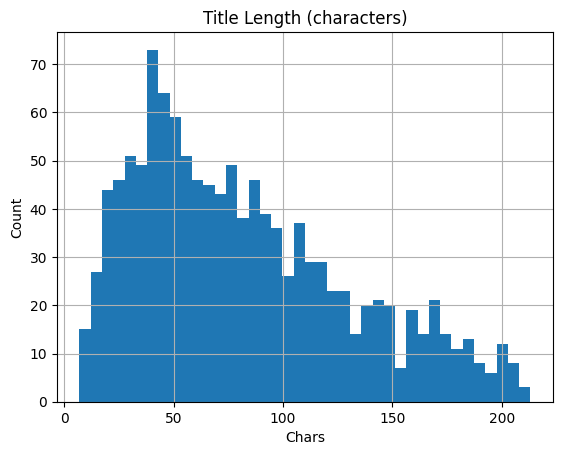

In [24]:
plt.figure()
df_clean["title_len"].hist(bins=40)
plt.title("Title Length (characters)")
plt.xlabel("Chars")
plt.ylabel("Count")
plt.show()

In [25]:
df_clean["title_len"].describe()


count    1199.000000
mean       81.874062
std        48.690361
min         7.000000
25%        43.000000
50%        72.000000
75%       112.500000
max       213.000000
Name: title_len, dtype: float64

----

### 2. Step 1: gross retrieving using Word Embedding (SBERT)


In this step we build a **baseline semantic retriever** using **Sentence-BERT (`all-mpnet-base-v2`)**.  

All cleaned job titles are encoded into dense embeddings (L2-normalized for cosine similarity).  

A simple retrieval function then compares a normalized **query** against all title vectors, returning the **top-N most similar titles** ranked by cosine score.  

This provides a fast, interpretable first-pass similarity layer, the foundation for constructing balanced training pairs and evaluating how well the later LLM ranker improves over embedding-only retrieval.


#### 2.1 import the SBERT model

In [26]:
from sentence_transformers import SentenceTransformer

In [27]:
text_col = "title_norm"
texts = df_clean[text_col].astype(str).tolist()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)
model.max_seq_length = 256  # plenty for the titles (max = 213 chars)

#### 2.2 Encode the titles

In [28]:
emb = model.encode(
    texts,
    batch_size=128,
    show_progress_bar=True,
    normalize_embeddings=True,      # cosine-ready
    convert_to_numpy=True
).astype(np.float32)

print("Shape:", emb.shape)          # (n_rows, 384)
print("Norm mean:", np.linalg.norm(emb, axis=1).mean())


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Shape: (1199, 768)
Norm mean: 1.0


In [29]:
# Copy the clean dataframe
df_model = df_clean.copy(deep=True)

In [30]:
# Create an immutable row index for embedding alignment
df_model = df_model.reset_index(drop=True)
df_model["emb_ix"] = df_model.index.astype("int32")

In [31]:
df_model.head()

,id,title,location,screening_score,title_norm,title_len,alpha_ratio,emb_ix
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,119.0,0.865546,0
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,198.0,0.833333,1
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,122.0,0.885246,2
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,201.0,0.880597,3
4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100,graduate research assistant at uab masters in data science student at uab ex jio,80.0,0.837500,4


In [32]:
# Keep a slim view for joining results
meta_cols = ["emb_ix","id","title","title_norm"]
meta = df_model[meta_cols].copy()

#### 2.3 Retrieval function (encode query -> top-N by cosine similarity)

In [33]:
from typing import Union, Tuple

In [34]:
def retrieve_top_n(
    query: str,
    n: int = 50    
) -> pd.DataFrame:
    """
    Normalize + encode `query` with the same model, compute cosine similarities to `emb`,
    fully sort all items (O(N log N)), and return a DataFrame with the top-n results.

    Requires in scope:
      - normalize_text (function)
      - model (SentenceTransformer used to build `emb`)
      - emb   (np.ndarray, shape [N, D], L2-normalized rows)
      - meta  (DataFrame with columns including ['emb_ix','id','title','title_norm'])
    """
    # Normalize query text exactly like corpus titles
    q_text = normalize_text(query)
    
    # Encode query. Normalize to make cosine a dot product
    q = model.encode([q_text], normalize_embeddings=True, convert_to_numpy=True).astype(np.float32)[0]

    # Cosine similarities (dot product since vectors are L2-normalized)
    sims = emb @ q  # shape (N,)

    # Bound n and get indices of the top-n by full sort (O(N log N))
    N = sims.shape[0]
    n = int(max(1, min(n, N)))
    idx_sorted_desc = np.argsort(sims)[::-1][:n]  # full sort, take top-n

    # Build output DataFrame with originals
    out = meta.loc[idx_sorted_desc].copy()
    out.insert(0, "rank", np.arange(1, len(idx_sorted_desc) + 1))
    out["similarity"] = sims[idx_sorted_desc]
    return out.reset_index(drop=True)

Run some tests:

In [35]:
tests = [
    "machine learning engineer",
    "data scientist",
    "project manager"
]

for q in tests:
    print(f"\nQuery: {q}")
    display(retrieve_top_n(q, n=5))



Query: machine learning engineer


,rank,emb_ix,id,title,title_norm,similarity
0,1,891,947,machine learning engineer,machine learning engineer,1.000000
1,2,979,1039,machine learning engineer 2,machine learning engineer 2,0.864124
2,3,1140,1221,Data Scientist Machine Learning Engineer,Data Scientist Machine Learning Engineer,0.849322
3,4,1155,1237,Machine Learning Engineer Data Scientist MLOps,Machine Learning Engineer Data Scientist MLOps,0.841134
4,5,23,25,data analyst and machine learning engineer,data analyst and machine learning engineer,0.800220



Query: data scientist


,rank,emb_ix,id,title,title_norm,similarity
0,1,194,201,data scientist,data scientist,1.000000
1,2,1097,1173,data analyst data scientist,data analyst data scientist,0.918813
2,3,405,419,data scientist analyst,data scientist analyst,0.914789
3,4,1018,1080,data scientistgeoscientist,data scientistgeoscientist,0.880559
4,5,72,74,data analyst,data analyst,0.875535



Query: project manager


,rank,emb_ix,id,title,title_norm,similarity
0,1,707,738,program manager,program manager,0.648391
1,2,841,888,operations manager assistant program coordinator,operations manager assistant program coordinator,0.593523
2,3,1145,1227,Advanced Google Certified Data Analyst Project Manager,Advanced Google Certified Data Analyst Project Manager,0.573546
3,4,765,804,engineering supervisor,engineering supervisor,0.569864
4,5,697,727,performance marketing manager,performance marketing manager,0.549647


Sanity checks

In [36]:
qs = [
    "machine learning engineer",
    "data scientist",
    "project manager",
    "product manager",
    "ml ops engineer",
    "computer vision scientist",
]
rows = []
for q in qs:
    top5 = retrieve_top_n(q, n=5)
    rows.append({
        "query": q,
        "top1_title": top5.loc[0, "title"],
        "top1_sim": float(top5.loc[0, "similarity"])        
    })


In [37]:
pd.DataFrame(rows).sort_values("top1_sim")

,query,top1_title,top1_sim
2,project manager,program manager,0.648391
3,product manager,performance marketing manager,0.685709
5,computer vision scientist,computer scientist,0.735877
4,ml ops engineer,Machine Learning Engineer Data Scientist MLOps,0.761466
0,machine learning engineer,machine learning engineer,1.000000
1,data scientist,data scientist,1.000000


----

### 3. Step 2: fine retrieving using an LLM

Here we introduce a **Large Language Model as a fine-grained ranker** to refine the SBERT retrieval results.  

We start by **building a supervised dataset**: for each query, we sample candidate titles across similarity bins (from unrelated to near-exact) and attach their SBERT cosine scores.  

The LLM (`Llama-3.2-3B-Instruct`) is then prompted to assign **0–100 similarity scores** using clear, rule-based instructions (v1 and v2 prompt variants).  

These LLM scores capture nuanced aspects like **seniority, role, and domain consistency** that embeddings miss.  

Finally, we **combine** SBERT and LLM scores into a **weighted final label**, flag uncertain cases for review, and export clean **train/val/test JSONL files** for instruction fine-tuning.


#### 3.1 Build the dataset (CSV) to instruct fine tune the LLM

#### 3.1.1 Baseline: calculate the SBERT + cosine similarity and add it to a .csv file then used to fine tune the LLM

In [38]:
list_of_queries = ["machine learning engineer", "data scientist", "back end developer", "front end developer", "full stack engineer", "software architect", "devops engineer", "site reliability engineer", "mobile application developer", "cloud solutions architect", "project manager", "product manager", "program manager", "bid manager", "business analyst", "scrum master", "agile coach", "chief executive officer", "chief technology officer", "operations manager", "financial analyst", "investment banker", "accountant junior", "accountant taxes senior", "auditor", "chief financial officer", "controller", "tax advisor", "payroll specialist", "budget analyst", "attorney", "paralegal", "legal consultant", "human resources manager", "recruiter", "talent acquisition specialist", "marketing specialist", "digital marketing manager", "sales representative", "business development manager", "data researcher", "nuclear physicist", "atomic physicist", "biomedical researcher", "chemist", "astronomer", "registered nurse", "physician assistant", "clinical psychologist", "medical laboratory technician"]
print(f'Number of queries: {len(list_of_queries)}')

Number of queries: 50


Now we will create a function to retrieve job candidates per querry following a balanced by bins considering the similarity score.

In [40]:
def retrieve_balanced_by_bins(
    query: str,
    total: int = 250,
    bin_edges: list[float] = [0.0, 0.2, 0.4, 0.6, 0.75, 0.85, 0.92, 0.97, 1.0],  # adjusted for a better balance
    per_bin: list[int] | None = None,
    min_per_bin: int = 10,
    shuffle_within_bin: bool = True,
    rng_seed: int = 23,
) -> pd.DataFrame:
    """
    Compute cosine sim for *all* titles, then sample roughly equal counts per bin.
    Returns a DataFrame like retrieve_top_n but with a 'bin' column.
    """
    q_text = normalize_text(query)
    if not q_text:
        return pd.DataFrame(columns=["rank","similarity","emb_ix","id","title","title_norm","bin"])

    q = model.encode([q_text], normalize_embeddings=True, convert_to_numpy=True).astype(np.float32)[0]
    sims = emb @ q  # (N,)

    # master table (descending rank for reference)
    order_desc = np.argsort(sims)[::-1]
    df_all = meta.loc[order_desc].copy()
    df_all["similarity"] = sims[order_desc]
    df_all["rank_desc"] = np.arange(1, len(df_all) + 1)

    # bin assignment
    bins = np.array(bin_edges, dtype=float)
    labels = [f"[{bins[i]:.2f},{bins[i+1]:.2f})" if i+1 < len(bins)-1 else f"[{bins[i]:.2f},{bins[i+1]:.2f}]"
              for i in range(len(bins)-1)]
    bin_idx = np.digitize(df_all["similarity"].to_numpy(), bins, right=False) - 1
    df_all["bin"] = pd.Categorical(
        [labels[i] if 0 <= i < len(labels) else "out" for i in bin_idx], categories=labels, ordered=True)

    # per-bin target counts
    n_bins = len(labels)
    if per_bin is None:
        base = total // n_bins
        per_bin = [max(min_per_bin, base)] * n_bins
        # new feature:
        # bonus for high bins (last 3 bins get +5 each)
        for j in range(-3, 0):
            per_bin[j] += 5
        # distribute remainder if any
        while sum(per_bin) > total:
            per_bin[0] -= 1  # trim from lowest bin
    else:
        assert len(per_bin) == n_bins, "per_bin must match number of bins"
        assert sum(per_bin) == total, "sum(per_bin) must equal total"

    rng = np.random.default_rng(rng_seed)
    pieces = []
    for lbl, k in zip(labels, per_bin):
        bin_df = df_all[df_all["bin"] == lbl]
        if len(bin_df) == 0:
            continue
        if shuffle_within_bin:
            bin_df = bin_df.sample(frac=1.0, random_state=rng.integers(0, 1_000_000))
        pieces.append(bin_df.head(min(k, len(bin_df))))
        
     # if we came up short (some bins were sparse), fill from nearest bins by descending rank
    balanced = pd.concat(pieces, ignore_index=True) if pieces else df_all.head(0)
    short = total - len(balanced)
    if short > 0:
        # exclude already picked. Fill by descending rank to ensure completion
        remaining = df_all.loc[~df_all.index.isin(balanced.index)]
        fill = remaining.head(short)
        balanced = pd.concat([balanced, fill], ignore_index=True)

    # sort for pretty output: by bin then by similarity desc    
    balanced = balanced.sort_values(["bin", "similarity"], ascending=[True, False]).reset_index(drop=True)
    # normalize to the output schema: add a 1..M rank column (not "top" rank, just display rank inside this set)
    balanced.insert(0, "rank", np.arange(1, len(balanced) + 1))
    # keep standard columns expected by your CSV builder
    cols = ["rank", "emb_ix", "id", "title", "title_norm", "similarity", "rank_desc", "bin"]
    
    return balanced[cols]

In [42]:
def sbert_cos_to_100(sim: float) -> int:
    """Map cosine similarity (0–1) to a 0–100 scale."""
    sim = float(np.clip(sim, 0.0, 1.0))
    return int(round(100 * sim))

def build_skeleton_csv(
    queries: list[str],
    N: int = 250,
    out_csv: str = os.path.join(DATA_DIR, "pairwise_llm_dataset_skeleton.csv")
) -> pd.DataFrame:
    """
    For each query:
      - retrieve_balanced_by_bins(query, total=N) -> balanced candidates
      - produce rows with SBERT cosine mapped to 0–100
      - leave LLM score columns empty (you will fill them later)
    """
    rows = []
    for q in queries:
        q_norm = normalize_text(q)
        cand = retrieve_balanced_by_bins(q_norm, total=N)  # balanced sampling
        for _, r in cand.iterrows():
            rows.append({
                "query": q,
                "query_norm": q_norm,
                "id": r["id"],
                "emb_ix": int(r["emb_ix"]),
                "title": r["title"],
                "title_norm": r.get("title_norm", r["title"]),
                "emb_rank": int(r["rank"]),                   # rank inside balanced sample
                "emb_rank_desc": int(r["rank_desc"]),         # global descending rank
                "bin": r["bin"],                              # bin label for traceability
                "emb_score": float(r["similarity"]),          # cosine (0–1)
                "emb_score_100": sbert_cos_to_100(r["similarity"]),
                # LLM scores (fill later)
                "llm_score_v1": np.nan,
                "llm_score_v2": np.nan,
                "llm_score_v3": np.nan,
                # Aggregates (compute later)
                "llm_score_median": np.nan,
                "llm_score_iqr": np.nan,
                "final_weighted": np.nan,
                "needs_review": np.nan,
                "notes": ""
            })
    df_csv = pd.DataFrame(rows)
    df_csv.to_csv(out_csv, index=False)
    print(f"Skeleton saved: {out_csv} | rows: {len(df_csv)}")
    return df_csv


In [43]:
# prepare the csv first version
df_ft_ds = build_skeleton_csv(
    list_of_queries,
    N=250) 

Skeleton saved: data\pairwise_llm_dataset_skeleton.csv | rows: 12500


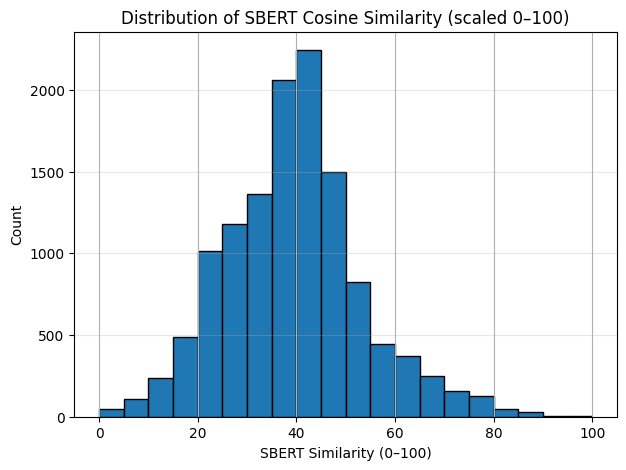

In [44]:
# plot the embedding scores histogram 
plt.figure(figsize=(7,5))
df_ft_ds["emb_score_100"].hist(bins=20, edgecolor="black")
plt.title("Distribution of SBERT Cosine Similarity (scaled 0–100)")
plt.xlabel("SBERT Similarity (0–100)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


#### 3.1.2 First LLM score: add a second score from the LLM

In [45]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [46]:
# load once
MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"
tok = AutoTokenizer.from_pretrained(MODEL_ID, token=os.getenv("HF_TOKEN"), use_fast=True)


In [47]:
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    token=os.getenv("HF_TOKEN"),
).eval()
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
# Prompt v1: same prompt builder used in the previous project part 4
def build_prompt_v1(query: str, title: str) -> str:
    """
    Chat-style prompt for scoring a single (query, title) pair with LLaMA.
    Returns a string ready to tokenize and pass into generate().
    """
    instr = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Return EXACTLY one integer 0–100.\n"
        "Scale:\n"
        " • 90–100 = exact/near-exact\n"
        " • 70–89  = very similar\n"
        " • 40–69  = related/adjacent\n"
        " • 10–39  = mostly unrelated\n"
        " • 0–9    = unrelated\n"
        "Return the integer ONLY (no words, no punctuation, no decimals)."
    )
    user = f'Query: "{query}"\nCandidate:\n{title}'
    messages = [
        {"role": "system", "content": instr},
        {"role": "user",   "content": user},
    ]
    try:
        return tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        # fallback: raw concatenation if chat template fails
        return instr + "\n\n" + user

# def parse_one_int(text: str) -> int:
#     m = re.findall(r"-?\d+", text)
#     if not m:
#         return 0
#     x = int(m[-1])
#     return max(0, min(100, x))

def parse_one_int(text: str):
    m = re.findall(r"-?\d+", text)
    return None if not m else max(0, min(100, int(m[-1])))

def score_one_pair(query: str, title: str, build_prompt_fn=build_prompt_v1, max_new_tokens: int = 6) -> int:
    """
    Score a (query, title) pair with LLaMA using the given prompt builder.
    
    Args:
        query (str): input query string
        title (str): candidate job title
        build_prompt_fn (callable): function (query, title) -> str, builds the prompt
        max_new_tokens (int): generation length, defaults to 6
    Returns:
        int: similarity score 0–100
    """
    
    prompt = build_prompt_fn(query, title)
    inputs = tok(prompt, return_tensors="pt").to(mdl.device)
    with torch.no_grad():
        out_ids = mdl.generate(
            **inputs,
            do_sample=False,
            num_beams=1,
            max_new_tokens=max_new_tokens,
            pad_token_id=tok.eos_token_id,
            use_cache=True,
        )
    out_txt = tok.decode(out_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return parse_one_int(out_txt)


In [49]:
score = score_one_pair("machine learning engineer", "data scientist", build_prompt_fn=build_prompt_v1, max_new_tokens=12)
print("Score:", score)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Score: 70


prompt builder v2: minimal changes, zero-shot with penalties & stricter output rule

In [50]:
def build_prompt_v2(query: str, title: str) -> str:
    """
    Zero-shot like v1, but with explicit penalty rules and a stricter output constraint.
    """
    instr = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Return EXACTLY one integer 0–100. DIGITS ONLY on the first line.\n"
        "Scale:\n"
        " • 90–100 = exact/near-exact\n"
        " • 70–89  = very similar\n"
        " • 40–69  = related/adjacent\n"
        " • 10–39  = mostly unrelated\n"
        " • 0–9    = unrelated\n"
        "Penalties (apply additively when relevant):\n"
        " • Seniority mismatch (intern/junior vs lead/principal): −10 to −25\n"
        " • Function mismatch (product vs project vs program manager, etc.): −20 to −35\n"
        " • Domain mismatch (CV vs NLP vs generic DS, etc.): −10 to −20\n"
        "Output ONLY the integer (no words, no punctuation, no decimals)."
    )
    user = f'Query: "{query}"\nCandidate:\n{title}'
    messages = [
        {"role": "system", "content": instr},
        {"role": "user",   "content": user},
    ]
    try:
        return tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        return instr + "\n\n" + user




In [51]:
score = score_one_pair("machine learning engineer", "data scientist", build_prompt_fn=build_prompt_v2, max_new_tokens=12)
print("Score:", score)

Score: 60


#### Compare the score dinamycs in a sample

                                                                                                                                              title  emb_score_100  llm_v1  llm_v2
                                                                              research analyst in cancer biology spatial transcriptomics multiomics             20      39      60
                                                             Researcher PHD Student University of Southeastern Philippines Healthcare Data Analysis             20      10      60
                                                                                  data analyst united health group data ethics statistical analysis             17      40      60
                                                          astrophysics researcher stars stellar dynamics black holes and gravitational waves at unc             17      10      60
                                                                                                         

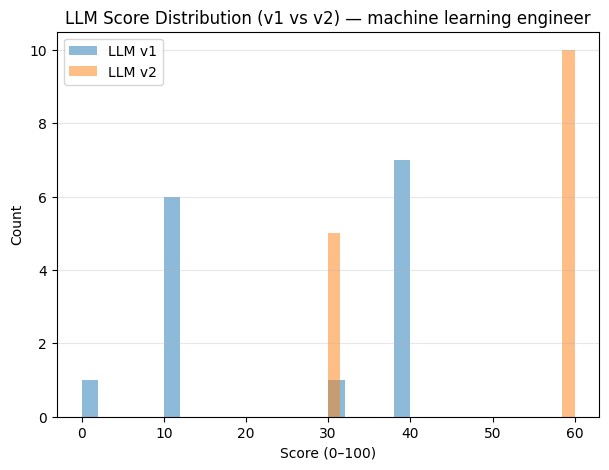

In [52]:
# pick one querry
Q = "machine learning engineer"
sample = df_ft_ds[df_ft_ds["query"] == Q].head(15).copy()  # adjust N if you want

def score_batch(query: str, titles: list[str], build_prompt_fn, max_new_tokens=12) -> list[int]:
    scores = []
    for t in titles:
        s = score_one_pair(query, t, build_prompt_fn=build_prompt_fn, max_new_tokens=max_new_tokens)
        scores.append(int(s))
    return scores

titles = sample["title"].tolist()
sample["llm_v1"] = score_batch(Q, titles, build_prompt_fn=build_prompt_v1, max_new_tokens=12)
sample["llm_v2"] = score_batch(Q, titles, build_prompt_fn=build_prompt_v2, max_new_tokens=12)

# quick view
print(sample[["title", "emb_score_100", "llm_v1", "llm_v2"]].head(10).to_string(index=False))

# simple stats
print("\nStats:")
print(sample[["emb_score_100","llm_v1","llm_v2"]].describe().round(2))

# correlation with SBERT (just to sanity-check consistency, not a target)
corr = sample[["emb_score_100","llm_v1","llm_v2"]].corr().round(2)
print("\nCorrelations:\n", corr)

# hist overlay
plt.figure(figsize=(7,5))
sample["llm_v1"].plot(kind="hist", bins=20, alpha=0.5, label="LLM v1")
sample["llm_v2"].plot(kind="hist", bins=20, alpha=0.5, label="LLM v2")
plt.title(f"LLM Score Distribution (v1 vs v2) — {Q}")
plt.xlabel("Score (0–100)")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


#### Fill the .csv file with the LLM score using the two prompts (v1 and v2)

In [53]:
from tqdm import tqdm

In [54]:
def score_rows_for_query_v1(df: pd.DataFrame, query: str, max_new_tokens: int = 12) -> pd.DataFrame:
    """
    Fill llm_score_v1 for all rows with this query.
    """
    m = (df["query"] == query) & (df["llm_score_v1"].isna())
    if not m.any():
        print(f"[v1] Nothing to do for query: {query}")
        return df

    rows = df.loc[m].copy()
    scores = []
    for title in tqdm(rows["title"].tolist(), desc=f"LLM v1 — {query}"):
        s = score_one_pair(query, title, build_prompt_fn=build_prompt_v1, max_new_tokens=max_new_tokens)
        scores.append(int(s))
    df.loc[m, "llm_score_v1"] = scores
    return df


def score_rows_for_query_v2(df: pd.DataFrame, query: str, max_new_tokens: int = 12) -> pd.DataFrame:
    """
    Fill llm_score_v2 for all rows with this query.
    """
    m = (df["query"] == query) & (df["llm_score_v2"].isna())
    if not m.any():
        print(f"[v2] Nothing to do for query: {query}")
        return df

    rows = df.loc[m].copy()
    scores = []
    for title in tqdm(rows["title"].tolist(), desc=f"LLM v2 — {query}"):
        s = score_one_pair(query, title, build_prompt_fn=build_prompt_v2, max_new_tokens=max_new_tokens)
        scores.append(int(s))
    df.loc[m, "llm_score_v2"] = scores
    return df

In [55]:
def fill_llm_scores(csv_path: str, queries: list[str], which: str = "both", save_after_each: bool = True):
    """
    Load CSV, fill llm_score_v1/v2 for the given queries (skips already-scored rows), and save.
    which: "v1" | "v2" | "both"
    """
    df = pd.read_csv(csv_path)

    for q in queries:
        if which in ("v1", "both"):
            df = score_rows_for_query_v1(df, q)
        if which in ("v2", "both"):
            df = score_rows_for_query_v2(df, q)

        if save_after_each:
            df.to_csv(csv_path, index=False)
            print(f"Saved after query: {q}")

    if not save_after_each:
        df.to_csv(csv_path, index=False)
        print("Saved all updates.")

    return df


In [57]:
csv_path = os.path.join(DATA_DIR, "pairwise_llm_dataset_skeleton.csv")
subset = ["machine learning engineer", "data scientist"]  # start small
df_ft_ds = fill_llm_scores(csv_path, subset, which="both")

LLM v2 — machine learning engineer: 100%|██████████| 250/250 [01:44<00:00,  2.40it/s]


Saved after query: machine learning engineer


LLM v2 — data scientist: 100%|██████████| 250/250 [01:43<00:00,  2.41it/s]

Saved after query: data scientist


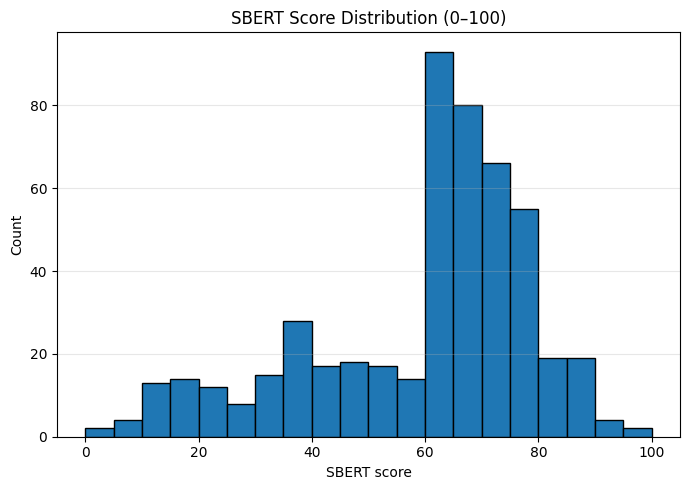

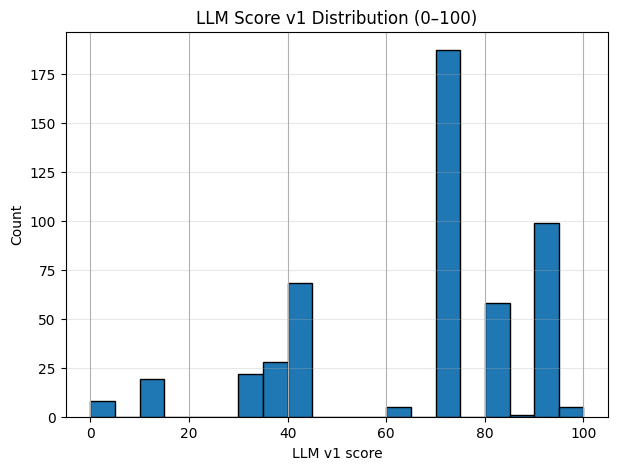

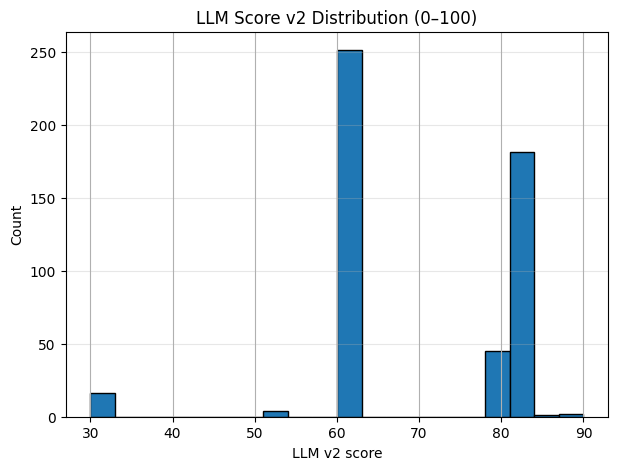

In [58]:
# SBERT
mask = df_ft_ds["query"].isin(["machine learning engineer", "data scientist"])
scores = pd.to_numeric(df_ft_ds.loc[mask, "emb_score_100"], errors="coerce").dropna()
plt.figure(figsize=(7, 5))
plt.hist(scores, bins=range(0, 101, 5), edgecolor="black")
plt.title("SBERT Score Distribution (0–100)")
plt.xlabel("SBERT score")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# v1
plt.figure(figsize=(7,5))
df_ft_ds["llm_score_v1"].dropna().astype(int).hist(bins=20, edgecolor="black")
plt.title("LLM Score v1 Distribution (0–100)")
plt.xlabel("LLM v1 score")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

# v2
plt.figure(figsize=(7,5))
df_ft_ds["llm_score_v2"].dropna().astype(int).hist(bins=20, edgecolor="black")
plt.title("LLM Score v2 Distribution (0–100)")
plt.xlabel("LLM v2 score")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


Interpretation
- v1 is more discriminative (spreads scores, uses the scale better).
- v2 is more conservative (tends to stay in a narrower band, avoids extremes).
Correlation earlier (0.42 between v1 and v2) shows they’re not redundant, they each bring something different.

Fill llm_score_v1 and llm_score_v2 across the CSV

In [119]:
# First, define the list of queries with no LLM scores
subset = (
    df_ft_ds.loc[df_ft_ds["llm_score_v1"].isna() | df_ft_ds["llm_score_v2"].isna(), "query"]
    .dropna()
    .unique()
    .tolist()
)

# fill both scores only for those queries
df_ft_ds = fill_llm_scores(csv_path, subset, which="both")


LLM v2 — back end developer: 100%|██████████| 250/250 [01:48<00:00,  2.30it/s]


Saved after query: back end developer


LLM v2 — front end developer: 100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


Saved after query: front end developer


LLM v2 — full stack engineer: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


Saved after query: full stack engineer


LLM v2 — software architect: 100%|██████████| 250/250 [01:58<00:00,  2.11it/s]


Saved after query: software architect


LLM v2 — devops engineer: 100%|██████████| 250/250 [01:58<00:00,  2.11it/s]


Saved after query: devops engineer


LLM v2 — site reliability engineer: 100%|██████████| 250/250 [02:05<00:00,  1.99it/s]


Saved after query: site reliability engineer


LLM v2 — mobile application developer: 100%|██████████| 250/250 [02:09<00:00,  1.93it/s]


Saved after query: mobile application developer


LLM v2 — cloud solutions architect: 100%|██████████| 250/250 [02:05<00:00,  2.00it/s]


Saved after query: cloud solutions architect


LLM v2 — project manager: 100%|██████████| 250/250 [01:53<00:00,  2.21it/s]


Saved after query: project manager


LLM v2 — product manager: 100%|██████████| 250/250 [01:58<00:00,  2.12it/s]


Saved after query: product manager


LLM v2 — program manager: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


Saved after query: program manager


LLM v2 — bid manager: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Saved after query: bid manager


LLM v2 — business analyst: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Saved after query: business analyst


LLM v2 — scrum master: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Saved after query: scrum master


LLM v2 — agile coach: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: agile coach


LLM v2 — chief executive officer: 100%|██████████| 250/250 [01:45<00:00,  2.38it/s]


Saved after query: chief executive officer


LLM v2 — chief technology officer: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: chief technology officer


LLM v2 — operations manager: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


Saved after query: operations manager


LLM v2 — financial analyst: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: financial analyst


LLM v2 — investment banker: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: investment banker


LLM v2 — accountant junior: 100%|██████████| 250/250 [01:44<00:00,  2.39it/s]


Saved after query: accountant junior


LLM v2 — accountant taxes senior: 100%|██████████| 250/250 [01:43<00:00,  2.42it/s]


Saved after query: accountant taxes senior


LLM v2 — auditor: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: auditor


LLM v2 — chief financial officer: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: chief financial officer


LLM v2 — controller: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


Saved after query: controller


LLM v2 — tax advisor: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: tax advisor


LLM v2 — payroll specialist: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: payroll specialist


LLM v2 — budget analyst: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


Saved after query: budget analyst


LLM v2 — attorney: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: attorney


LLM v2 — paralegal: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: paralegal


LLM v2 — legal consultant: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: legal consultant


LLM v2 — human resources manager: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


Saved after query: human resources manager


LLM v2 — recruiter: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


Saved after query: recruiter


LLM v2 — talent acquisition specialist: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: talent acquisition specialist


LLM v2 — marketing specialist: 100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Saved after query: marketing specialist


LLM v2 — digital marketing manager: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: digital marketing manager


LLM v2 — sales representative: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


Saved after query: sales representative


LLM v2 — business development manager: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: business development manager


LLM v2 — data researcher: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: data researcher


LLM v2 — nuclear physicist: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: nuclear physicist


LLM v2 — atomic physicist: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


Saved after query: atomic physicist


LLM v2 — biomedical researcher: 100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


Saved after query: biomedical researcher


LLM v2 — chemist: 100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


Saved after query: chemist


LLM v2 — astronomer: 100%|██████████| 250/250 [01:49<00:00,  2.27it/s]


Saved after query: astronomer


LLM v2 — registered nurse: 100%|██████████| 250/250 [01:48<00:00,  2.29it/s]


Saved after query: registered nurse


LLM v2 — physician assistant: 100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


Saved after query: physician assistant


LLM v2 — clinical psychologist: 100%|██████████| 250/250 [01:48<00:00,  2.30it/s]


Saved after query: clinical psychologist


LLM v2 — medical laboratory technician: 100%|██████████| 250/250 [01:48<00:00,  2.30it/s]

Saved after query: medical laboratory technician


In [67]:
#  import ad-hoc tool kit
import importlib, tools_llm_ift
importlib.reload(tools_llm_ift)


<module 'tools_llm_ift' from 'e:\\Devs\\pyEnv-1\\Apziva\\Potential_Talents_-_Yc1Y0PqXJsbGtBoy\\tools_llm_ift.py'>

In [60]:
# compute final_weighted = 0.3*emb + 0.5*v1 + 0.2*v2 (0..100 scale),
# and flag needs_review (~top 1% by disagreement between 3 scores or any missing component).

out_csv = os.path.join(DATA_DIR, "pairwise_llm_dataset_ready.csv")

df_ft_ds = tools_llm_ift.finalize_scores(
    csv_path,
    out_csv=out_csv,
    w_emb=0.3,
    w_v1=0.5,
    w_v2=0.2,
    review_frac=0.01)

print("Flagged rows:", int(df_ft_ds["needs_review"].sum()))
df_ft_ds[["emb_score_100","llm_score_v1","llm_score_v2","final_weighted","needs_review"]].head()

Saved: data\pairwise_llm_dataset_ready.csv  | flagged: 12000 rows
Flagged rows: 12000


,emb_score_100,llm_score_v1,llm_score_v2,final_weighted,needs_review
0,20,39.0,60.0,37.5,0
1,20,10.0,60.0,23.0,0
2,17,40.0,60.0,37.1,0
3,17,10.0,60.0,22.1,0
4,17,10.0,60.0,22.1,0


In [61]:
# Create the JSON files with: train (80%), val (10%) and test (10%) splits at the query level, 
# drops needs_review==1, and writes three chat JSONL files using final_weighted as the target.
                    
res = tools_llm_ift.build_finetune_jsonl_3way(
    csv_path=os.path.join(DATA_DIR, "pairwise_llm_dataset_ready.csv"),
    out_dir="ft_data",
    label_col="final_weighted",
    drop_review=False,   
    val_frac=0.10,
    test_frac=0.10,
    seed=23,
)
res



Wrote train: 0 rows -> ft_data\llama_pairwise_train.jsonl
Wrote val: 250 rows -> ft_data\llama_pairwise_val.jsonl
Wrote test: 250 rows -> ft_data\llama_pairwise_test.jsonl


{'paths': {'train': 'ft_data\\llama_pairwise_train.jsonl',
  'val': 'ft_data\\llama_pairwise_val.jsonl',
  'test': 'ft_data\\llama_pairwise_test.jsonl'},
 'stats': {'rows_total': 500,
  'rows_train': 0,
  'rows_val': 250,
  'rows_test': 250,
  'queries_total': 2,
  'queries_train': 0,
  'queries_val': 1,
  'queries_test': 1,
  'fractions_queries': {'train': 0.0, 'val': 0.5, 'test': 0.5}}}

----

### 4) Instruction FT (in a separate training notebook “Part 5t”)

To keep environments clean and GPU memory stable, the **instruction fine-tuning** is done in a **separate notebook: _Part 5t (t = training)_**, with a venv dedicated to versions needed for **LoRA**.

**What 5t does (brief):**
- Loads the JSONL built here (balanced bins, final weighted label).
- Builds chat prompts and **masks prompt tokens**, supervising **only the numeric target (0–100) + EOS**.
- Trains `meta-llama/Llama-3.2-3B-Instruct` with **LoRA**.
- Logs key curves (train/eval loss, LR) and writes a compact `summary.json`.

After 5t finishes, we return to **this notebook (Part 5)** to:
- **Load the trained adapter** onto the base model,
- Score/rank queries end-to-end,
- Compare against SBERT, and run small sanity checks on ranking quality.

----

### 5) Use the Instruction FT model

In [62]:
from peft import PeftModel, PeftConfig
from transformers import AutoTokenizer, AutoModelForCausalLM

In [63]:
# Adapter path
adapter_dir = "runs/llama_pairwise_lora/adapter"

# Load tokenizer saved during training (ensures identical tokenization)
tok = AutoTokenizer.from_pretrained("runs/llama_pairwise_lora/tokenizer", use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

# Load the correct base model (derive id from the adapter config for safety)
peft_cfg = PeftConfig.from_pretrained(adapter_dir)
base_id = peft_cfg.base_model_name_or_path  # should be meta-llama/Llama-3.2-3B-Instruct

base = AutoModelForCausalLM.from_pretrained(
    base_id,
    dtype=torch.float16,        # matches the LoRA training dtype
    device_map="auto",
    token=os.getenv("HF_TOKEN"),
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [64]:
# Attach the LoRA adapter
model = PeftModel.from_pretrained(base, adapter_dir)
model.eval()
model.config.use_cache = True  # re-enable cache for generation

e:\Devs\pyEnv-1\venvs\Pot-Tals_LLM_env\Lib\site-packages\accelerate\utils\modeling.py:1582: UserWarning: Current model requires 256 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


In [65]:
QUERIES = ["data scientist", "machine learning engineer", "backend developer", "product manager"]  # same queries from Part 3 and 4
df_base_ds = pd.read_csv(base_ds_file)
TITLES_extended = df_base_ds['title'].astype(str).tolist()

In [68]:
top10_instruct_llama, path_instruct_llama = tools_llm_ift.run_query_instruct_llama_pairwise(
    queries=QUERIES,
    titles=TITLES_extended,
    mdl=model,
    tok=tok,
    model_tag="llama-3.2-3b-instruct_FT-pairwise",
    limit=200  #test
)


Scoring titles for query: data scientist  (N=200)


KeyboardInterrupt: 